In [150]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [151]:
df_train = pd.read_csv('./train.csv')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [152]:
df_train = df_train.dropna()
df_train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [153]:
from sklearn.metrics import accuracy_score


numeric_cols = df_train.select_dtypes(include=[np.number]).columns.tolist()
X = df_train[[c for c in numeric_cols]].drop(columns=['Survived'])
y = df_train['Survived']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42,
)

model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)
preds = model.predict(X_test)

accuracy_score(y_test, preds)

0.7027027027027027

In [154]:
df = pd.read_csv('./train.csv')

# Важные признаки
В контексте выживания имеют смысл признаки, котрые отражают напрямую или косвенно социальный статус и достаток. 
Pclass и Fare необходимы, тк у более обеспеченных лучшие места и более быстрый доступ к шлюпкам.
Тк пол и возраст влияли на приоритет посадки в шлюпки, то Age и Sex нужны.
Также важны признаки SibSp и Parch, тк люди будут спасать родственников и шанс выжить меньше, если семьи большие на корабле.

PassengerId, Name, Ticket, Cabin, Embarked - неинформативные, зашумленные или с огромными пропусками их нет смысла рассматривать.

In [155]:
df = df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Survived']]

In [156]:
missing_counts = df.isnull().sum()
missing_percent = (missing_counts / len(df)) * 100

pd.DataFrame({'count': missing_counts, 'percent': missing_percent.round(2)})

,count,percent
Pclass,0,0.00
Sex,0,0.00
Age,177,19.87
SibSp,0,0.00
Parch,0,0.00
Fare,0,0.00
Survived,0,0.00


Удаление приведет к поетере 20% датасета. Заполню пропуски в Age медианой, которая более устойчива к выбросам.

In [157]:
df['Age'] = df['Age'].fillna(df['Age'].median())

In [158]:
outliers = {}
numeric_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    low_border = Q1 - 1.5 * IQR
    high_border = Q3 + 1.5 * IQR
    mask_outliers = (df[col] < low_border) | (df[col] > high_border)
    outliers[col] = mask_outliers.sum()

pd.DataFrame.from_dict(outliers, orient='index', columns=['кол-во выбросов'])

,кол-во выбросов
Pclass,0
Age,66
SibSp,46
Parch,213
Fare,116
Survived,0


Удалять нет смысла, тк выбросы это реальные случаи просто в данном контексте они выпадают, например людей довольно старых было мало или семтей с большим числом детей тоже. 
Имеет смысл прологарифмировать цену, чтобы огромная стоимость первого класса не сбивала модель

In [159]:
df['Fare'] = np.log1p(df['Fare'])

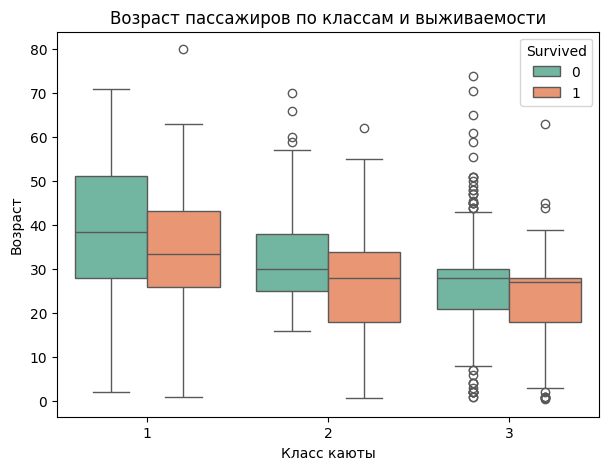

In [160]:
plt.figure(figsize=(7,5))
sns.boxplot(data=df, x='Pclass', y='Age', hue='Survived', palette='Set2')
plt.title('Возраст пассажиров по классам и выживаемости')
plt.xlabel('Класс каюты')
plt.ylabel('Возраст')
plt.show()

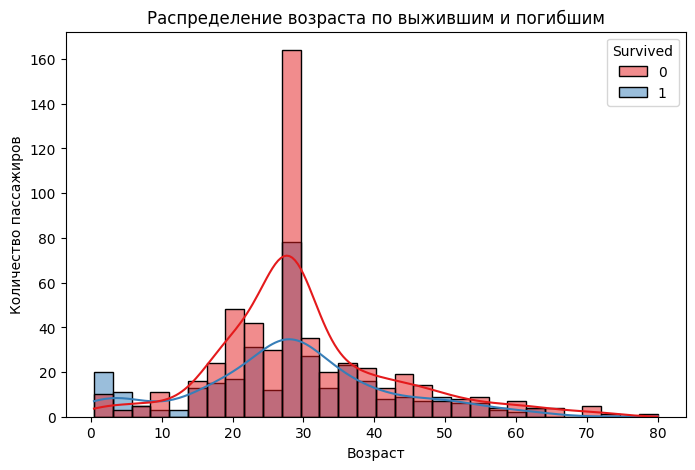

In [161]:
plt.figure(figsize=(8,5))
sns.histplot(data=df, x='Age', hue='Survived', bins=30, kde=True, palette='Set1')
plt.title('Распределение возраста по выжившим и погибшим')
plt.xlabel('Возраст')
plt.ylabel('Количество пассажиров')
plt.show()

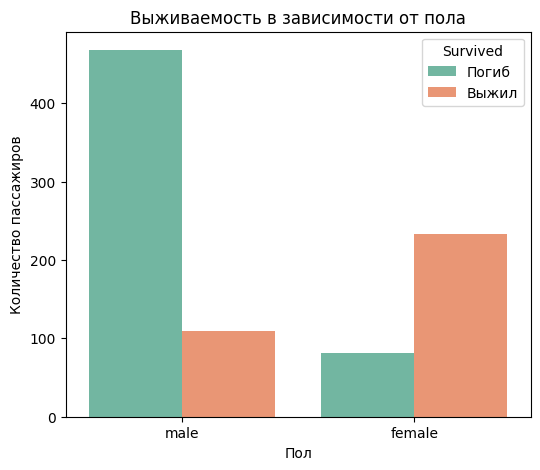

In [162]:
plt.figure(figsize=(6,5))
sns.countplot(data=df, x='Sex', hue='Survived', palette='Set2')
plt.title('Выживаемость в зависимости от пола')
plt.xlabel('Пол')
plt.ylabel('Количество пассажиров')
plt.legend(title='Survived', labels=['Погиб', 'Выжил'])
plt.show()

В каждом классе больше выживших среди более молодых людей. Также чем выше класс тем старше людей в среднем.
Со стороны детей больше выживших, а также пожилые люди с большей вероятностью погибали.
Также женщин погибло гораздо меньше в процентах от общего числа по каждому полу.

In [163]:
X = df.drop(columns=['Survived'])
y = df['Survived']
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare
0,3,male,22.0,1,0,2.110213
1,1,female,38.0,1,0,4.280593
2,3,female,26.0,0,0,2.188856
3,1,female,35.0,1,0,3.990834
4,3,male,35.0,0,0,2.202765


In [164]:
X = pd.get_dummies(X, columns=['Sex'], drop_first=True)
X.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_male
0,3,22.0,1,0,2.110213,True
1,1,38.0,1,0,4.280593,False
2,3,26.0,0,0,2.188856,False
3,1,35.0,1,0,3.990834,False
4,3,35.0,0,0,2.202765,True


Закодируем возраст через интервалы возраста и будем хранить мин и макс возраст в группе

In [165]:
X['AgeGroup'] = pd.cut(
    X['Age'],
    bins=[0, 5, 12, 18, 25, 35, 45, 55, 65, 80],
    labels=['0-5','6-12','13-18','19-25','26-35','36-45','46-55','56-65','66-80']
)

age_groups = X.groupby('AgeGroup')['Age'].agg(['min','max']).to_dict()

X['Age_min'] = X['AgeGroup'].map(age_groups['min']).astype(int)
X['Age_max'] = X['AgeGroup'].map(age_groups['max']).astype(int)

X = X.drop(columns=['Age','AgeGroup'])

X.head()

C:\Users\Misha\AppData\Local\Temp\ipykernel_26852\1376758620.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_groups = X.groupby('AgeGroup')['Age'].agg(['min','max']).to_dict()


,Pclass,SibSp,Parch,Fare,Sex_male,Age_min,Age_max
0,3,1,0,2.110213,True,19,25
1,1,1,0,4.280593,False,36,45
2,3,0,0,2.188856,False,26,35
3,1,1,0,3.990834,False,26,35
4,3,0,0,2.202765,True,26,35


In [166]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42,
)

model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)
preds = model.predict(X_test)

accuracy_score(y_test, preds)

0.8156424581005587

# Преобразования 
- Проверены и обработаны пропуски:
  - `Age` → заполнен медианой (устойчиво к выбросам);
  - `Cabin` → убран, т.к. очень много пропусков.
- Категориальный признак (`Sex`) закодирован в числовой формат через `pd.get_dummies`.
- Признак `Fare` преобразован через логарифмирование (`np.log1p`) для уменьшения влияния выбросов.
- Признак `Age` преобразован в группы интервалов; для каждой группы сохранены нижняя (`Age_min`) и верхняя (`Age_max`) границы как новые числовые признаки.
- Исключены нерелевантные признаки как не несущие полезной информации в исходном виде.

---

# Сравнение метрик
- Модель на "сырых" данных (без обработки) показала метрику около **0.703**.
- После предобработки, кодирования категориальных признаков, обработки пропусков и добавления новых признаков (`Age_min`, `Age_max`) метрика улучшилась и стала **0.816**.

---

# Вывод
С данными работать необходимо, тк результат сильно зависит как от самой модели, так и от самих данных, их обработки и анализа.
Для **больших данных** необходимость в исследовании и преобразовании сохраняется. Тк в них может быть гораздо больше выбросов некорректных значений или обработка даст еще больше прироста метрики